--------------------------------------------------------------------------------------------
PCA completed successfully with latitude weighting!
--------------------------------------------------------------------------------------------
<xarray.Dataset> Size: 157kB
Dimensions:  (lev: 54, lat: 121)
Dimensions without coordinates: lev, lat
Data variables:
    PC1      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
    PC2      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
    PC3      (lev, lat) float64 52kB nan nan nan nan nan ... nan nan nan nan nan
--------------------------------------------------------------------------------------------
Explained variance ratio: [0.48629786 0.16027418 0.11504427]
--------------------------------------------------------------------------------------------


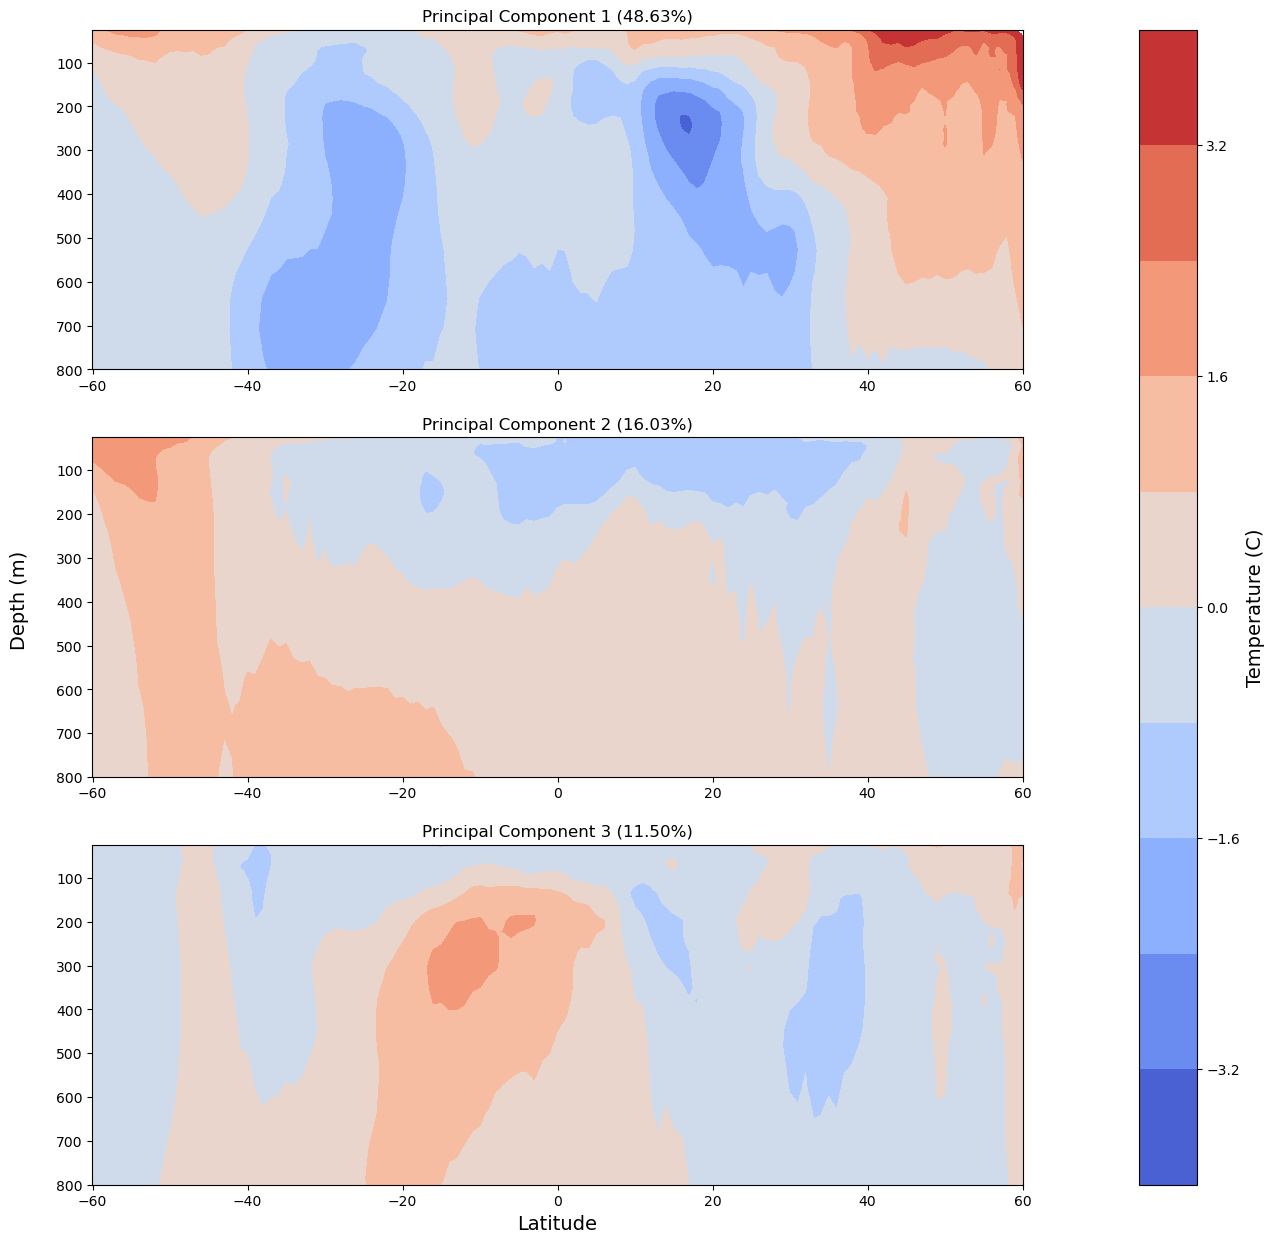

In [3]:
import xarray as xr
import numpy as np 
import pandas as pd
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
suppress_warnings = True 
suppress_plots = False 
if suppress_warnings:
    warnings.filterwarnings("ignore")
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

# Open dataset
ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Latlev Anomaly Files/latlev_anom_models.nc')

# Exclude unwanted models
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA Late Plio', 'MCA Early Plio']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Remove NaN values
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

# Extract latitude values
latitudes = ds['lat'].values

# Compute latitude weights (sqrt of cosine of latitude)
lat_weights = np.sqrt(np.cos(np.radians(latitudes)))

# Expand weights to match the data structure
lat_weights_2d = np.tile(lat_weights[:, np.newaxis], (ds.sizes['lev'], 1))  
lat_weights_flat = lat_weights_2d.flatten()[~nan_mask]  # Flatten and apply NaN mask

# Apply latitude weighting to the data
weighted_data = clean_data_matrix * lat_weights_flat[:, np.newaxis]

# Perform PCA on weighted data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(weighted_data)

# Reconstruct into original grid
restored_pca = np.full((data_matrix.shape[0], pca_result.shape[1]), np.nan)  # Placeholder
restored_pca[~nan_mask] = pca_result  # Restore valid positions

# Convert back to xarray
pca_ds = xr.Dataset({
    f'PC{i+1}': (['lev', 'lat'], restored_pca[:, i].reshape(ds.sizes['lev'], ds.sizes['lat'])) 
    for i in range(pca_result.shape[1])
})

# Save PCA results
pca_ds.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/pca_results.nc')

# Print results
print('--------------------------------------------------------------------------------------------')
print('PCA completed successfully with latitude weighting!')
print('--------------------------------------------------------------------------------------------')
print(pca_ds)
print('--------------------------------------------------------------------------------------------')
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('--------------------------------------------------------------------------------------------')

# Define number of PCs to visualize
num_components = min(4, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

# Initialize a variable to store the last mappable object
last_pcm = None

for i in range(num_components):
    ax = axes[i]

    # Plot PCA result as an image (Depth vs. Latitude) 
    levels = np.linspace(-4, 4, 11)  # Adjust levels as needed
    pcm = ax.contourf(ds['lat'], ds['lev'], pca_ds[f'PC{i+1}'], cmap='coolwarm', levels=levels)
    last_pcm = pcm  # Store the last mappable object

    # Formatting
    ax.set_title(f'Principal Component {i+1} ({variance[i]:.2f}%)')
    ax.set_ylim([800, 25])
    ax.set_xlim([ds['lat'].min(), ds['lat'].max()]) 

# Add a single colorbar for all subplots
cbar = fig.colorbar(last_pcm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.1, pad=0.1)
ax.set_xlabel('Latitude', fontsize = 14)
fig.supylabel('Depth (m)', fontsize=14, x = 0.07)
cbar.set_label('Temperature (C)', fontsize = 14)

# Save and show plot
#plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/PCA_LatitudeVSDepth.pdf', dpi=300, bbox_inches="tight")
plt.show()